### Import the Library ###

In [7]:
# inspired by https://www.kaggle.com/nickycan/lb-0-3805009-python-edition
import numpy as np   ## linear algebra
import pandas as pd  ## data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split  ## split train and test
from IPython.display import display ## Allows the use of display() for DataFrames

import matplotlib.pyplot as plt  ## data visualization

import gc   ## clean up 
import time ## time it

from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [8]:
class setup_your_clock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))

### Load the Dataset from Feature Engineering ###

In [9]:
## access to hdf5 file
df_data = pd.read_hdf('saved_df_data_whole.h5', 'df_data')

### Train / Test ###

In [10]:
print(df_data.columns)
print(df_data.shape)

Index(['user_id', 'product_id', '_up_order_count', '_up_first_order_number',
       '_up_last_order_number', '_up_average_cart_position', '_prod_tot_cnts',
       '_prod_reorder_tot_cnts', '_prod_buy_first_time_total_cnt',
       '_prod_buy_second_time_total_cnt', '_prod_reorder_prob',
       '_prod_reorder_ratio', '_user_total_orders',
       '_user_sum_days_since_prior_order', '_user_mean_days_since_prior_order',
       '_user_reorder_ratio', '_user_total_products',
       '_user_distinct_products', '_user_average_basket', 'order_id',
       'eval_set', 'time_since_last_order', '_up_order_rate',
       '_up_order_since_last_order', '_up_order_rate_since_first_order',
       'reordered'],
      dtype='object')
(13307953, 26)


### Save the Table Into LaTeX Format ###  
Because the table is a long which doesn't fit in one line, we split it into three segments instead.

In [11]:
#display(df_data[:100].describe().applymap('{:,.2f}'.format))
display(df_data.iloc[:100, :9].describe().applymap('{:.2f}'.format))

,user_id,product_id,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,15.24,18290.49,2.46,4.45,7.32,12.01,10500.63,7652.30,2848.33
std,6.84,12191.47,2.58,3.23,4.79,9.45,39539.90,32592.96,7282.05
min,1.00,196.00,1.00,1.00,1.00,1.00,5.00,0.00,4.00
25%,15.00,10412.25,1.00,1.00,4.00,4.00,230.00,72.75,125.75
50%,19.00,16227.00,1.00,4.00,7.00,9.67,1287.00,556.00,559.50
75%,19.00,23120.00,3.00,7.00,9.00,17.25,6688.75,3749.25,2673.00
max,19.00,49235.00,11.00,15.00,22.00,39.00,379450.00,315913.00,63537.00


In [12]:
## print(df_data.iloc[:, :9].describe().applymap('{:.2f}'.format).to_latex())

In [13]:
## print(df_data.iloc[:, 9:18].describe().applymap('{:.2f}'.format).to_latex())

In [14]:
## print(df_data.iloc[:, 18:].describe().applymap('{:.2f}'.format).to_latex())

### Split the Data ###

In [15]:
df_train = df_data[df_data['eval_set'] == "train"].copy()
df_train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
df_train.loc[:, 'reordered'] = df_train.reordered.fillna(0)

In [16]:
## display(df_train.head(4))

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns = df_train.columns.values)


In [18]:
display(df_train.head(4))

,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt,_prod_buy_second_time_total_cnt,_prod_reorder_prob,_prod_reorder_ratio,...,_user_mean_days_since_prior_order,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_average_basket,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,reordered
0,0.091837,0.000000,0.091837,0.002778,0.075736,0.069720,0.108160,0.084472,0.582500,0.825010,...,0.651852,0.759259,0.015406,0.023448,0.070758,0.466667,1.000000,0.00000,1.000000,1.0
1,0.081633,0.010204,0.091837,0.016204,0.004116,0.003485,0.007518,0.005583,0.552962,0.758383,...,0.651852,0.759259,0.015406,0.023448,0.070758,0.466667,0.898980,0.00000,1.000000,1.0
2,0.000000,0.040816,0.040816,0.027778,0.011692,0.009039,0.025989,0.018181,0.521581,0.692759,...,0.651852,0.759259,0.015406,0.023448,0.070758,0.466667,0.090816,0.05102,0.158163,0.0
3,0.091837,0.000000,0.091837,0.015972,0.013702,0.012034,0.022689,0.016115,0.529482,0.787031,...,0.651852,0.759259,0.015406,0.023448,0.070758,0.466667,1.000000,0.00000,1.000000,0.0


In [19]:
## We can only use X_test for on-line competition submission. 
## X_test = df_data.loc[df_data['eval_set'] == "test"]

X_df_train_raw, X_val_raw, y_df_train_raw, y_val_raw =  train_test_split(df_train.drop('reordered', axis=1), 
                                                        df_train.reordered,
                                                        test_size=0.1, random_state=42)

In [20]:
print(X_df_train_raw.shape)
print(X_val_raw.shape)
print(y_df_train_raw.shape)
print(y_val_raw.shape)

(7627194, 21)
(847467, 21)
(7627194,)
(847467,)


### Subset Testing Stage ### 

In [21]:
print("-"*10 + " Original size" + "-"*10 )
print(X_df_train_raw.shape)
X_df_train = X_df_train_raw.sample(frac=0.1, random_state=311)
y_df_train = y_df_train_raw.sample(frac=0.1, random_state=311)
print("-"*10 + " Subset size" + "-"*10 )
print(X_df_train.shape)

---------- Original size----------
(7627194, 21)
---------- Subset size----------
(762719, 21)


In [22]:
X_val = X_val_raw.sample(frac=0.1, random_state=311)
y_val = y_val_raw.sample(frac=0.1, random_state=311)

### Model Evaluation: Quantifying the Quality of Predictions ### 

### Input Desired Threshold of the Probability ###

In [23]:
## define the threshold. 
## If probability is higher than this, we predict the item will be put in the cart
defined_threshold = 0.3

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import r2_score, f1_score

## http://scikit-learn.org/stable/modules/model_evaluation.html

def performance_metric(y_true, y_predict, threshold= defined_threshold):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    ## Calculate the performance score between 'y_true' and 'y_predict'
    ##score = r2_score(y_true, y_predict)
    
    #Converting probabilities into 1 or 0 
    y_pred_threshold = y_predict.copy()
    for i in range(0,len(y_predict)): 
        if y_predict[i]>=threshold:       # setting threshold (critical for our problem!)
            y_pred_threshold[i]=1 
        else: 
            y_pred_threshold[i]=0 
    
    
    score = f1_score(y_true, y_pred_threshold)
    ## Classification metrics can't handle a mix of binary and continuous targets
    ## modification required
    
    ## Return the score
    return score

def fit_model_with_threshold(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    # 0.17
    # http://lijiancheng0614.github.io/scikit-learn/modules/generated/sklearn.cross_validation.ShuffleSplit.html
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.20, random_state = 123)

    ## Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    ## Create a dictionary for the parameter 'max_depth' with a range from 3 to 6 
    params = {'max_depth':[x for x in range(3,7)]}

    ## Transform 'performance_metric' into a scoring function using 'make_scorer' 
    #scoring_fnc = make_scorer(performance_metric)
    scoring_fnc = make_scorer(performance_metric)

    ## Create the grid search object
    grid = GridSearchCV(regressor, params, scoring=scoring_fnc, cv=cv_sets)

    ## Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    ## Return the optimal model after fitting the data
    print("This is your best fitting score: {}".format(grid.grid_scores_))
    return grid.best_estimator_
    #return grid.best_estimator_, grid.grid_scores_

/Users/udothemath1984/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/udothemath1984/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Check Whether There is Missing Data(NaN) ###

In [25]:
## print(X_df_train.isnull().values.any())
print(y_df_train.isnull().values.any())
nan_rows = []
if y_df_train.isnull().values.any():
    nan_rows = X_df_train[X_df_train.isnull().any(1)]
print(len(nan_rows))
#display(nan_rows[1100:1110])

False
0


### Fit the Model ###

In [26]:
# X_df_train, X_val, y_df_train, y_val
## Fit the training data to the model using grid search

with setup_your_clock("fit the decision tree model"):
    reg = fit_model_with_threshold(X_df_train, y_df_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))


fit the decision tree model begin ......
This is your best fitting score: [mean: 0.37182, std: 0.00244, params: {'max_depth': 3}, mean: 0.39479, std: 0.00420, params: {'max_depth': 4}, mean: 0.38050, std: 0.00947, params: {'max_depth': 5}, mean: 0.40098, std: 0.00890, params: {'max_depth': 6}]
fit the decision tree model end ......
time lapsing 322.93188214302063 s 

Parameter 'max_depth' is 6 for the optimal model.


### Save/Load the Model ###

In [27]:
import pickle
saving_model = True

filename = 'm1_DecisionTree_model_normalization.p'

if saving_model: 
    ## save the model to disk
    pickle.dump(reg, open(filename, 'wb'))
else:
    ## load the model from disk
    reg = pickle.load(open(filename, 'rb'))
    

### Prediction ###

In [28]:
## X_df_train, X_val, y_df_train, y_val
## make sure the index of X_val and y_val are the same while sampling
def size_of_your_val(desired_frac, desired_rand_state=311):
    X_val_sub = X_val.sample(frac=desired_frac, random_state=desired_rand_state)
    y_val_sub = y_val.sample(frac=desired_frac, random_state=desired_rand_state)
    print("Number of entry in your test: {}.".format(X_val_sub.shape[0]))
    return X_val_sub, y_val_sub

In [29]:
validation_size = 1.0
the_X_val, the_y_val =  size_of_your_val(validation_size) 
## display(the_X_val.head(3))
## display(the_y_val.head(3))

Number of entry in your test: 84747.


In [30]:
the_y_pred = reg.predict(the_X_val)
#Converting probabilities into 1 or 0 based on the threshold
y_pred_threshold = the_y_pred.copy()
for i in range(0,len(the_y_pred)): 
    if the_y_pred[i]>=defined_threshold:       # setting threshold (critical for our problem!)
        y_pred_threshold[i]=1 
    else: 
        y_pred_threshold[i]=0 

### Output the Scores of your Prediction

In [31]:
from sklearn.metrics import f1_score
your_pred_score = f1_score(the_y_val, y_pred_threshold)
print(your_pred_score)

0.401123301985


Here I report the f1\_score with different thresholds.

| threshold | f1_score | 
|-----|------|
|0.1|0.364437913299|
|0.2|0.421511782542|
|0.3|0.401123301985|

As what we expect, the threshold plays an important role to determine the goodness of the prediction. It is intuitive since the probability of buying some items is directly related the final shopping cart. We will eliberate more in the report and have to tackle the same problem using other algorithms.


### Dominant Features ###

In [35]:
from sklearn.feature_selection import SelectKBest, f_regression
most_important_features = 21
featureSelector = SelectKBest(score_func=f_regression,k=most_important_features)
featureSelector.fit(X_df_train,y_df_train)
print("The index of feature importance. Note: Index starts from zero.")
print("You have selected {} most important features out of {}.".format(most_important_features, X_df_train.shape[1] ))
imp_feature_selected_ind = [zero_based_index for zero_based_index in list(featureSelector.get_support(indices=True))]
#print(imp_feature_selected_ind)
imp_feature_selected_type = X_df_train.columns[imp_feature_selected_ind]
#print(imp_feature_selected_type)
imp_feature_scores = featureSelector.scores_[imp_feature_selected_ind]
#print(imp_feature_scores)

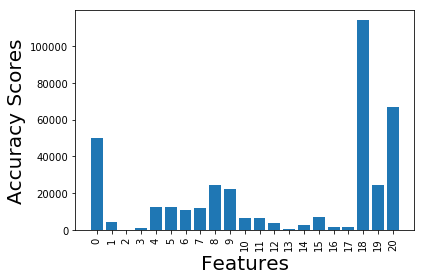

In [49]:

import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 20

#plt.rc('axes.labelsize', fontsize=18)    # legend fontsize


plt.bar(range(len(imp_feature_selected_ind)), imp_feature_scores)
plt.xticks(range(len(imp_feature_selected_ind)), imp_feature_selected_ind, rotation='vertical')

plt.xlabel('Features')
plt.ylabel('Accuracy Scores')

plt.tight_layout()
plt.savefig('./figures/fig_dominant_features.png')

plt.show()

select_n_most_important = 10

type_scores_pairs = pd.DataFrame({
    'Type' : imp_feature_selected_type,
    'Scores' : imp_feature_scores}, columns=['Type','Scores'])\
    .sort_values(by='Scores', ascending=False)[:select_n_most_important]

type_scores_pairs['Rank'] = list(range(1, select_n_most_important+1 ))    
type_scores_pairs = type_scores_pairs.reindex_axis(['Rank', 'Type', 'Scores'], axis=1)

In [52]:
display(type_scores_pairs[['Rank', 'Type']])
#print(type_scores_pairs[['Rank', 'Type']].to_latex(index=False))
#print(type_scores_pairs[['Rank', 'Type']].to_latex())

,Rank,Type
18,1,_up_order_rate
20,2,_up_order_rate_since_first_order
0,3,_up_order_count
19,4,_up_order_since_last_order
8,5,_prod_reorder_prob
9,6,_prod_reorder_ratio
4,7,_prod_tot_cnts
5,8,_prod_reorder_tot_cnts
7,9,_prod_buy_second_time_total_cnt
6,10,_prod_buy_first_time_total_cnt


### Note: Decision Tree (Scaling) ###

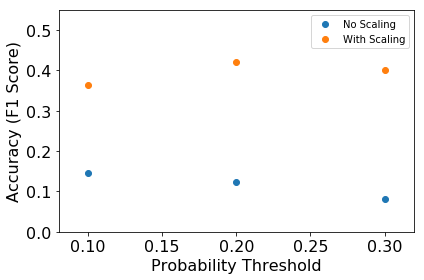

In [17]:
decision_no_scale = [(0.1, 0.14681), (0.2, 0.1225590 ), (0.3, 0.080233)]
decision_with_scale = [(0.1,0.36443), (0.2, 0.421511 ), (0.3, 0.401123)]

import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

p1x, p1y = zip(*decision_no_scale)
p2x, p2y = zip(*decision_with_scale)

plt.xlabel("Probability Threshold")
plt.ylabel("Accuracy (F1 Score)")
plt.ylim(0, 0.55)
plt.scatter(p1x, p1y, label='No Scaling')
plt.scatter(p2x, p2y, label='With Scaling')
plt.legend()
plt.tight_layout()
plt.savefig('./figures/fig_norm_compare.png')


plt.show()